<a href="https://colab.research.google.com/github/thaonguyyen/linearRegression/blob/main/Copy_of_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: Linear Models
## Foundations of Machine Learning
## Do Q1 and one other question

**Q1.** Load `./data/Q1_clean.csv`. The data include

- `Price` per night
- `Review Scores Rating`: The average rating for the property
- `Neighbourhood `: The bourough of NYC. Note the space, or rename the variable.
- `Property Type`: The kind of dwelling
- `Room Type`: The kind of space being rented

1. Compute the average prices and scores by `Neighbourhood `; which bourough is the most expensive on average? Create a kernel density plot of price and log price, grouping by `Neighbourhood `.
2. Regress price on `Neighbourhood ` by creating the appropriate dummy/one-hot-encoded variables, without an intercept in the linear model and using all the data. Compare the coefficients in the regression to the table from part 1. What pattern do you see? What are the coefficients in a regression of a continuous variable on one categorical variable?
3. Repeat part 2, but leave an intercept in the linear model. How do you have to handle the creation of the dummies differently? What is the intercept? Interpret the coefficients. How can I get the coefficients in part 2 from these new coefficients?
4. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood `. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?
5. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood ` and `Property Type`. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?
6. What does the coefficient on `Review Scores Rating` mean if it changes from part 4 to 5? Hint: Think about how multilple linear regression works.
7. (Optional) We've included `Neighborhood ` and `Property Type` separately in the model. How do you interact them, so you can have "A bedroom in Queens" or "A townhouse in Manhattan". Split the sample 80/20 into a training and a test set and run a regression including that kind of "property type X neighborhood" dummy, plus `Review Scores Rating`. How does the slope coefficient for `Review Scores Rating`, the $R^2$, and the RMSE change? Do they increase significantly compares to part 5? Are the coefficients in this regression just the sum of the coefficients for `Neighbourhood ` and `Property Type` from 5? What is the most expensive kind of property you can rent?

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [40]:
url = 'https://raw.githubusercontent.com/DS3001/linearRegression/main/data/Q1_clean.csv'
df = pd.read_csv(url)
df.head()

,Price,Review Scores Rating,Neighbourhood,Property Type,Room Type
0,549,96.0,Manhattan,Apartment,Private room
1,149,100.0,Brooklyn,Apartment,Entire home/apt
2,250,100.0,Manhattan,Apartment,Entire home/apt
3,90,94.0,Brooklyn,Apartment,Private room
4,270,90.0,Manhattan,Apartment,Entire home/apt


In [41]:
#1
df = df.rename(columns={'Neighbourhood ': 'Neighbourhood'})
df.loc[:, ['Price', 'Neighbourhood']].groupby('Neighbourhood').describe()

Price                                                      \
                 count        mean         std   min     25%    50%    75%   
Neighbourhood                                                                
Bronx            217.0   75.276498   39.755468  10.0   50.00   60.0   90.0   
Brooklyn        8487.0  127.747378  106.038466  20.0   75.00  100.0  150.0   
Manhattan      11763.0  183.664286  170.434606  25.0  103.00  150.0  214.0   
Queens          1590.0   96.857233   61.712648  25.0   60.00   80.0  115.0   
Staten Island     96.0  146.166667  508.462029  35.0   54.75   71.0   99.0   

                        
                   max  
Neighbourhood           
Bronx            244.0  
Brooklyn        4500.0  
Manhattan      10000.0  
Queens           950.0  
Staten Island   5000.0

Manhattan is the most expensive neighbourhood on average.

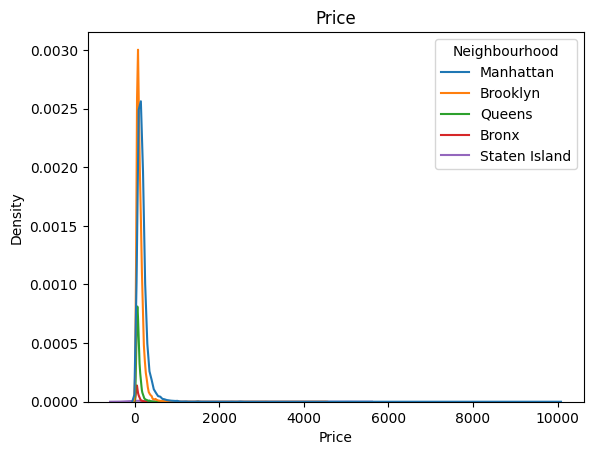

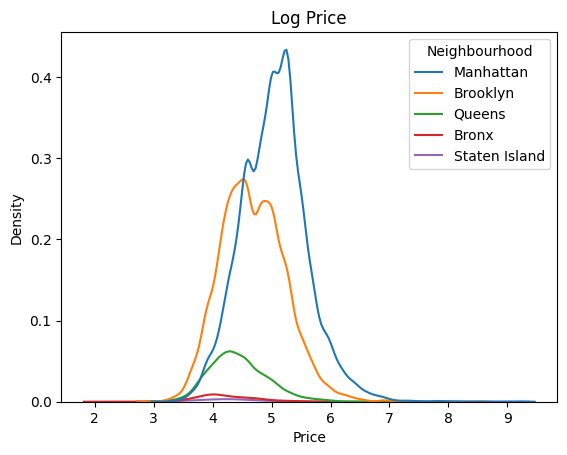

In [42]:
sns.kdeplot(x=df['Price'], hue=df['Neighbourhood'])
plt.title('Price')
plt.show()

log_price = np.log(df['Price'])
sns.kdeplot(x=log_price, hue=df['Neighbourhood'])
plt.title('Log Price')
plt.show()

Based on the kernel plots, if we just look at the most expensive prices in the neighbourhoods overall not on average, then Brooklyn has the highest prices.

In [43]:
#2
from sklearn import linear_model

price = df['Price']
X = pd.get_dummies(df['Neighbourhood'], dtype = 'int')
regression = linear_model.LinearRegression(fit_intercept=False).fit(X,price)
results = pd.DataFrame({'variable': regression.feature_names_in_, 'coefficient': regression.coef_})
results

,variable,coefficient
0,Bronx,75.276498
1,Brooklyn,127.747378
2,Manhattan,183.664286
3,Queens,96.857233
4,Staten Island,146.166667


The coefficient is the same value as the price mean for the neighbourhoods. There are no other control variables so the regression is just calculating the group averages.

In [44]:
#3
price = df['Price']
X = pd.get_dummies(df['Neighbourhood'], dtype = 'int', drop_first = True)
regression = linear_model.LinearRegression().fit(X,price)
results = pd.DataFrame({'variable': regression.feature_names_in_, 'coefficient': regression.coef_})
results

,variable,coefficient
0,Brooklyn,52.470881
1,Manhattan,108.387789
2,Queens,21.580735
3,Staten Island,70.890169


In [45]:
intercept = regression.intercept_
print(intercept)

75.27649769585331


The Bronx category became the reference category and its coefficient from the previous question (2) became the intercept. Now, the coefficients are all relative to the Bronx. You can add the regression coefficient values from the other neighbourhoods to the new intercept to get the same values from the previous regression.

In [46]:
#4
from sklearn import linear_model
from sklearn.model_selection import train_test_split

y = df['Price']
X = df.loc[:,['Review Scores Rating', 'Neighbourhood'] ]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=100)

Z_train = pd.concat([X_train['Review Scores Rating'],
                     pd.get_dummies(X_train['Neighbourhood'], dtype='int')], axis = 1)
Z_test = pd.concat([X_test['Review Scores Rating'],
                    pd.get_dummies(X_test['Neighbourhood'], dtype='int')], axis = 1)

regression = linear_model.LinearRegression(fit_intercept=False).fit(Z_train,y_train)

y_hat = regression.predict(Z_test)
print('Rsq: ', regression.score(Z_test,y_test)) # R2
rmse = np.sqrt( np.mean( (y_test - y_hat)**2 ))
print('RMSE: ', rmse) # R2

results = pd.DataFrame({'variable':regression.feature_names_in_, 'coefficient': regression.coef_})
results

Rsq:  0.06701086106947296
RMSE:  125.01092061382933


,variable,coefficient
0,Review Scores Rating,1.032257
1,Bronx,-17.261392
2,Brooklyn,32.180888
3,Manhattan,89.421020
4,Queens,4.050208
5,Staten Island,61.576393


In [47]:
review_scores = 1.032257
manhattan = 89.421020

expensive = 100*review_scores + manhattan
print(expensive)

192.64672000000002


The most expensive 100-rated place you can rent is in Manhattan for about 192.65 per night.

In [48]:
#5
y = df['Price']
X = df.loc[:,['Review Scores Rating', 'Neighbourhood', 'Room Type'] ]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=100)

Z_train = pd.concat([X_train['Review Scores Rating'],
                    pd.get_dummies(X_train['Neighbourhood'], dtype='int'),
                    pd.get_dummies(X_train['Room Type'], dtype='int')],
                    axis = 1)
Z_test = pd.concat([X_test['Review Scores Rating'],
                    pd.get_dummies(X_test['Neighbourhood'], dtype='int'),
                    pd.get_dummies(X_test['Room Type'], dtype='int')],
                    axis = 1)

regression = linear_model.LinearRegression(fit_intercept=False).fit(Z_train,y_train)

y_hat = regression.predict(Z_test)
print('Rsq: ', regression.score(Z_test,y_test)) # R2
rmse = np.sqrt( np.mean( (y_test - y_hat)**2 ))
print('RMSE: ', rmse) # R2

results = pd.DataFrame({'variable':regression.feature_names_in_, 'coefficient': regression.coef_})
results

Rsq:  0.22035348129282306
RMSE:  114.27692123130633


,variable,coefficient
0,Review Scores Rating,0.626912
1,Bronx,-13.022765
2,Brooklyn,10.378456
3,Manhattan,53.693304
4,Queens,-6.833330
5,Staten Island,50.003022
6,Entire home/apt,110.617820
7,Private room,3.101341
8,Shared room,-19.500474


In [49]:
review_scores = 0.626912
entire_home = 110.617820
manhattan = 53.693304

expensive = 100*review_scores + entire_home + manhattan
print(expensive)

227.002324


The most expensive place you can rent that is 100-rated is an entire home in Manhattan which is about 227 per night.

6) Part 4 had a coefficient of 1.03 and part 5 had a coefficient of 0.63. Part 4 did not include information about the room type and part 5 included that specification which impact the linear regression. Because there is correlation with room type as this varies the total prices in the neighbourhoods, the added variable, the predictive power increases when we add the room type variable.

**Q3.** This is a question about linear regression. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running the following regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

In [50]:
#1
url = 'https://raw.githubusercontent.com/DS3001/linearRegression/main/data/pretrial_data.csv'
df = pd.read_csv(url)

#clean data
df['held'] = df['held_wo_bail'].astype(int)
df['sex'] = df['sex'].replace(['M','F'],['Male','Female'])
df['Black'] = (df['race']=='B').astype(int)

rdf = df.loc[:,['held','Black','sex','case_type','is_poor','prior_F']]
rdf = rdf.dropna()
rdf['held'].value_counts()
df.head()

,Unnamed: 0,case_type,age,sex,race,is_poor,bond,bond_type,prior_F,prior_M,gini,released,sentence_type,sentence,bond_NA,held_wo_bail,sentence_NA,held,Black
0,0,F,31.0,Male,W,NaN,NaN,7,0.0,0.0,0.44,NaN,NaN,NaN,True,False,True,0,0
1,1,F,60.0,Male,B,NaN,NaN,7,13.0,21.0,0.44,0.0,0.0,60.000000,True,False,False,0,1
2,2,M,27.0,Male,W,NaN,NaN,7,0.0,0.0,0.44,0.0,1.0,12.000000,True,False,False,0,0
3,3,M,27.0,Male,B,0.0,NaN,7,0.0,9.0,0.44,0.0,1.0,0.985626,True,False,False,0,1
4,4,F,28.0,Female,W,0.0,NaN,7,0.0,0.0,0.44,1.0,4.0,0.000000,True,False,True,0,0


In [51]:
#2
df['Black'] = (df['race']=='B').astype(int)

In [52]:
#3
from sklearn import linear_model

y = df['held']
X = pd.get_dummies(df['Black'], dtype='int')
reg = linear_model.LinearRegression(fit_intercept=False).fit(X,y)
results = pd.DataFrame({'variable': X.columns, 'coefficient': reg.coef_})
results

,variable,coefficient
0,0,0.229521
1,1,0.302333


In [53]:
r_squared = reg.score(X, y)
r_squared

0.006655027631113586

The coefficient on the Black dummy variable is around 0.3 which is more than the other coefficient of 0.223. The R squared value is 0.006655027631113586.

In [54]:
#4
sex_dummies = pd.get_dummies(rdf['sex'],dtype='int',drop_first=True)
case_type_dummies = pd.get_dummies(rdf['case_type'],dtype='int',drop_first=True)

# Black and Sex
y = rdf['held']
X = pd.concat([rdf['Black'],sex_dummies],axis=1)
reg = LinearRegression().fit(X,y)
sdf = pd.DataFrame({'variable': X.columns, 'slope':reg.coef_})
sdf

,variable,slope
0,Black,0.063244
1,Male,0.101377


In [55]:
## Black and Sex and is_poor
y = rdf['held']
X = pd.concat([rdf.loc[:,['Black','is_poor']],sex_dummies],axis=1)
reg = LinearRegression().fit(X,y)
sdf = pd.DataFrame({'variable': X.columns, 'slope':reg.coef_})
sdf

,variable,slope
0,Black,0.036386
1,is_poor,0.185337
2,Male,0.114845


In [56]:
## Black and Sex and is_poor and prior_F
y = rdf['held']
X = pd.concat([rdf.loc[:,['Black','is_poor','prior_F']],sex_dummies],axis=1)
reg = LinearRegression().fit(X,y)
sdf = pd.DataFrame({'variable': X.columns, 'slope':reg.coef_})
sdf

,variable,slope
0,Black,0.026643
1,is_poor,0.167606
2,prior_F,0.026004
3,Male,0.097799


In [57]:
## Black and Sex and is_poor and prior_F and case_type
y = rdf['held']
X = pd.concat([rdf.loc[:,['Black','is_poor','prior_F']],sex_dummies,case_type_dummies],axis=1)
reg = LinearRegression().fit(X,y)
sdf = pd.DataFrame({'variable': X.columns, 'slope':reg.coef_})
sdf

,variable,slope
0,Black,0.019542
1,is_poor,0.073680
2,prior_F,0.016164
3,Male,0.084493
4,I,-0.508384
5,M,-0.421186
6,S,-0.139857


In [58]:
#5
rdf['race_sex'] = rdf['Black'].replace([0,1],['Other','Black'])+'_'+rdf['sex']

y = rdf['held']
X = pd.get_dummies(rdf['race_sex'],dtype=int)
reg = LinearRegression(fit_intercept=False).fit(X,y)
sdf = pd.DataFrame({'variable': X.columns, 'slope':reg.coef_})
sdf

,variable,slope
0,Black_Female,0.174618
1,Black_Male,0.347722
2,Other_Female,0.196509
3,Other_Male,0.253858


Black females have a probability of 0.17 of being held without bail which is the lowest of all race and sex combinations. Black males have the highest probability of being held without bail which is 0.35. Other races lie in between these two values which is interesting that the race that we are studying has both the lowest and highest percentage of being held without bail which shows that race has some sort of correlation.

6) I believe that this tool just uses past data to predict certain trends and in this case, how a case might be decided. Because this model is so dependent on analyzing old data, it will be reflective of these times. It must be updated constantly in order to generate somewhat consistent results with modern times. I think that it is important to analyze this data, especially in the sense of race, but we should be careful to not rely on these models entirely.